# Predict the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 80/10/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 652.56
- MAE: 508.45289917295
- MAPE: 1.50 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> CMG - 8 1 1
split = 2  # 8 1 1
stock = 1  # CMG

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [6]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [7]:
# Shape of the dataframe
df.shape

(1313, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

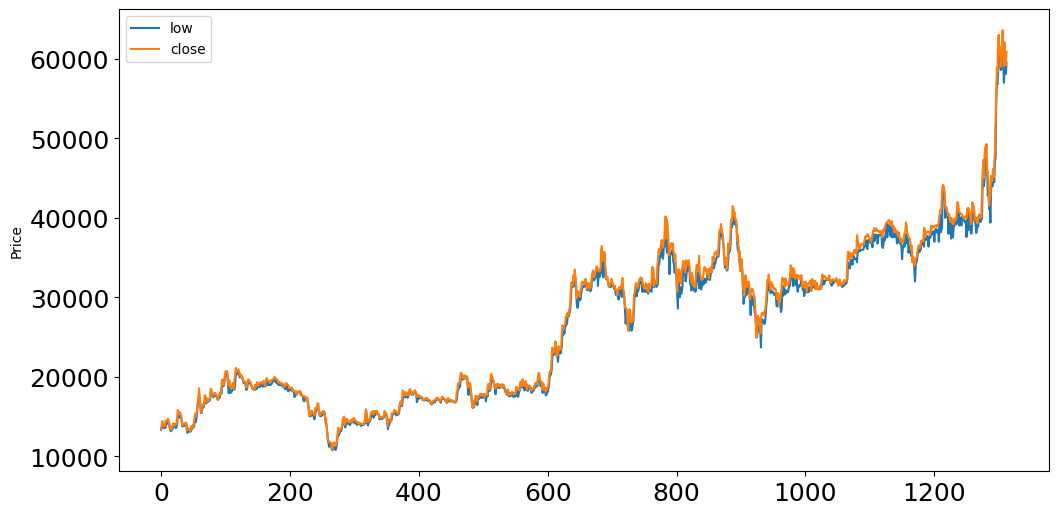

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963428,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.429
Failed to Reject Ho - Time Series is Non-Stationary


ADF Test on 'close' -> p-value: 0.483
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


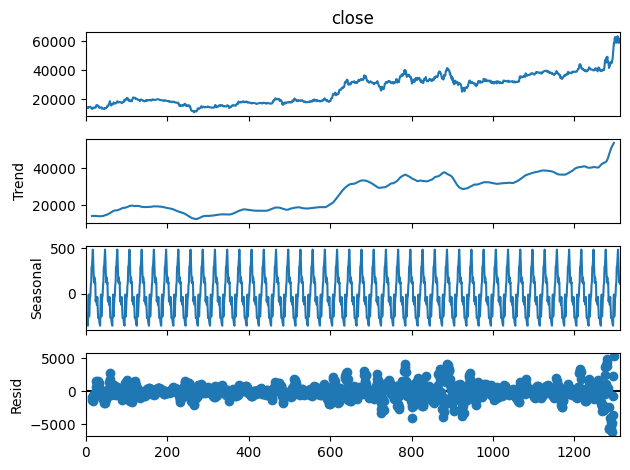

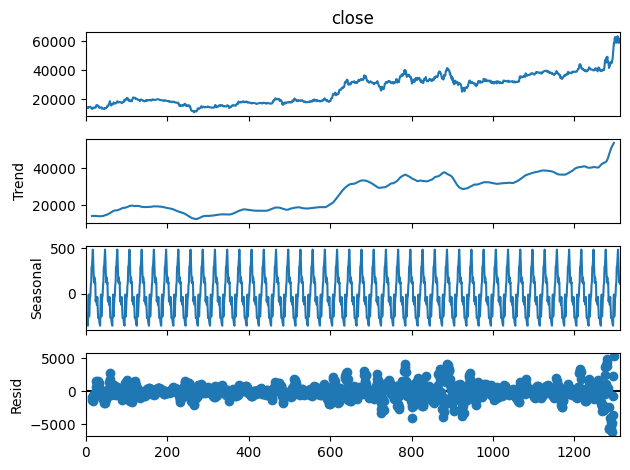

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-24.869647352545105,
 0.0,
 1,
 1047,
 {'1%': -3.4366111317433443,
  '5%': -2.864304451252086,
  '10%': -2.5682419034417707},
 16133.139050489852)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

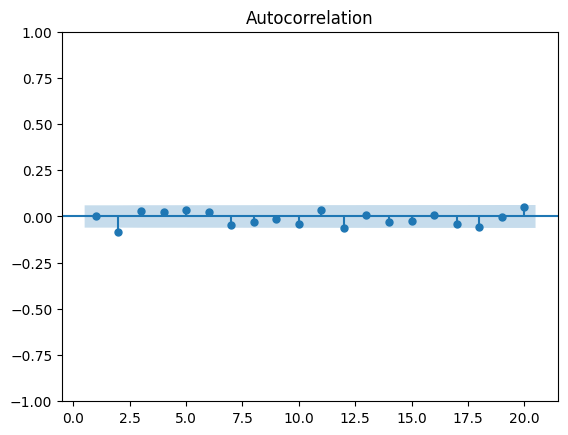

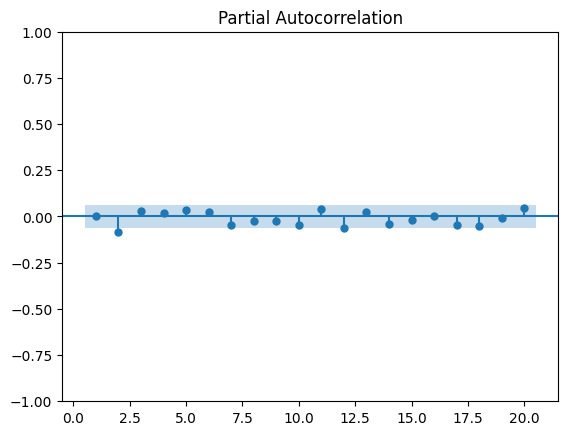

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=4.90 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=16483.650, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=16486.468, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=16486.376, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=16482.487, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=16484.497, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=16484.403, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=16485.947, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=16485.604, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=16485.598, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=16481.867, Time=0.91 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept   : AIC=16483.779, Time=1.07 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=16483.769, Time=1.13 sec
 ARIMA(1,1,1)(1,0,1)[5] intercept   : AIC=16485.701, Time=1.85 sec
 ARIMA(2,1,1)(0,0,0)[5] i

In [23]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1050
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -8237.077
Date:                Thu, 06 Jun 2024   AIC                          16480.153
Time:                        22:26:06   BIC                          16495.020
Sample:                             0   HQIC                         16485.791
                               - 1050                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0123      0.021      0.597      0.551      -0.028       0.053
ma.L2         -0.0743      0.021     -3.472      0.001      -0.116      -0.032
sigma2      3.887e+05   1.07e+04     36.275      0.0

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(0, 0, 1, 5),
)

model_fit = model1.fit()

C:\Users\datdao2003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([32085.73141185, 31773.17407495, 32173.95443425, 32046.01598671,
       31955.52831944, 31847.05889921, 31848.23215796, 31590.75452318,
       31740.15075035, 31741.52450773, 31779.83836196, 31993.81514239,
       32179.99946618, 31959.2227676 , 32182.30819378, 32470.08704244,
       34459.46730306, 34210.77761879, 34211.74724082, 33778.02129248,
       34685.22840677, 34797.06841192, 34501.96105956, 34216.07022775,
       34799.46655597, 35234.86475973, 34939.638261  , 34866.33815309,
       34866.99652557, 34941.61436529, 34507.56493521, 35673.40648999,
       35673.97041238, 35961.20273449, 35961.72464156, 35814.25779363,
       35962.70975199, 35963.17443194, 35963.62146626, 35964.051525  ,
       35964.46525279, 36399.52201998, 36325.92045466, 36437.26551937,
       37047.99175576, 37048.33267326, 36040.62226675, 36910.25528439,
       37123.26416612, 36836.86636166, 36938.87592612, 36976.13841335,
       36689.70859005, 36837.92764411, 36255.5405776 , 37411.7793746 ,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([36682.01649364, 36693.14120476, 36733.24728199, 36281.62678642,
       38114.73529021, 37312.66148138, 37054.88910172, 37417.03138742,
       37529.43538053, 37530.80913792, 36302.13897563, 37385.43325644,
       37321.92000034, 37378.58505719, 38027.08117505, 37704.48816174,
       37844.25671943, 38076.46607792, 38077.43569996, 36876.1208949 ,
       38125.50617423, 38357.57094007, 38358.40146018, 37943.03780916,
       38082.52732867, 38268.22795254, 36881.73054908, 39240.66983053,
       40027.41317676, 37993.47367513, 38271.52475068, 38549.55268805,
       42896.70411234, 42989.72720564, 42897.76852756, 42250.90651984,
       39661.93315785, 40448.48281156, 40448.92984587, 39940.71668631,
       39709.92895123, 37814.47497272, 39387.02782301, 39526.11706327,
       39202.78938968, 37261.0380191 , 39342.17915648, 38695.13057772,
       37400.70592156, 38649.48583053, 38742.24733648, 39204.92051539,
       38927.7387506 , 38927.98886842, 39020.71007348, 39991.98770019,
      

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[39384.31365506 39415.1005137  39437.87650439 39440.57690655
 39480.72808898 39493.64945994 39514.48486621 39535.61501736
 39556.70445582 39577.74036073 39598.72412842 39619.65771053
 39640.54301156 39661.38186485 39682.1760342  39702.92721643
 39723.63704392 39744.30708707 39764.93885663 39785.533806
 39806.09333338 39826.61878387 39847.11145151 39867.57258118
 39888.00337049 39908.40497159 39928.77849286 39949.12500059
 39969.44552059 39989.74103972]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

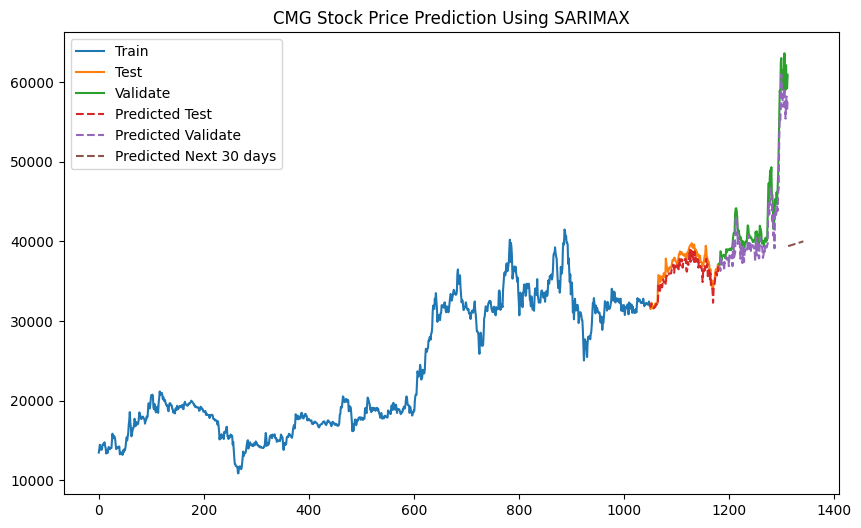

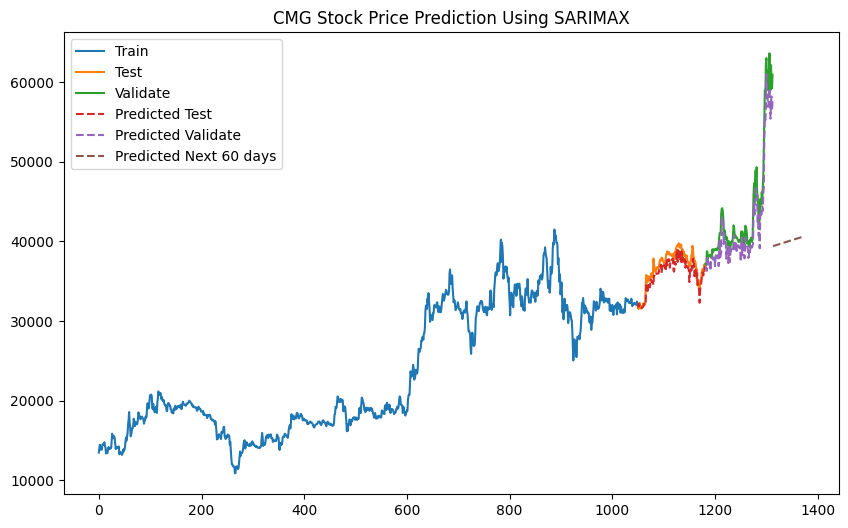

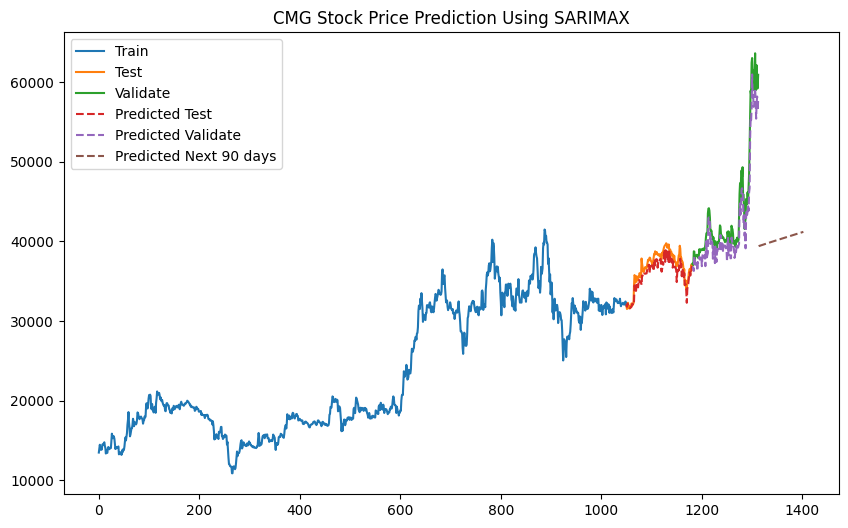

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 1035.3529702155404
MAE on test data: 850.2548054511819
MAPE on test data: 2.2772849629407244 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 1973.3511930275304
MAE on validation data: 1605.733435800584
MAPE on validation data: 3.524419584034682 %
